# Random Forest

Random Forest is an ensemble learning method that is used for classification, regression, and other machine learning tasks. It works by constructing a large number of decision trees, each of which is trained on a randomly sampled subset of the training data and a random subset of the input features. The goal is to create a diverse set of decision trees that are not overly correlated with each other, which can help to reduce overfitting and improve generalization performance.

During the training phase, the Random Forest algorithm constructs a large number of decision trees, typically hundreds or even thousands. Each tree is trained on a randomly selected subset of the training data, chosen with replacement (a technique known as "bootstrap sampling").

At each node of each decision tree, the algorithm selects a random subset of the input features, and chooses the feature and split threshold that maximizes a scoring criterion such as Gini impurity or information gain. This process is repeated recursively until each leaf node contains only instances from a single class (in the case of classification) or a single predicted value (in the case of regression).

During the testing phase, each decision tree in the forest produces a predicted output for the input data point. The final output of the Random Forest algorithm is then determined by a majority vote (in the case of classification) or an average (in the case of regression) of the outputs of all the decision trees in the forest.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)

### Data Imports

In [2]:
with open('pickles/df.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head(2)

,DISCOVERY_DOY,STAT_CAUSE_DESCR,STATE,SOURCE_SYSTEM_TYPE,duration,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,SOURCE_REPORTING_UNIT_NAME,FIRE_YEAR,FIRE_SIZE,elevation,bdod,cec,cfvo,clay,nitrogen,phh2o,sand,silt,soc
1,133,Lightning,CA,FED,0.0,A,38.933056,-120.404444,Eldorado National Forest,2004,0.25,1842,102.0,335.0,246.0,140.0,466.0,58.0,550.0,309.0,741.0
2,152,Negligence,CA,FED,0.0,A,38.984167,-120.735556,Eldorado National Forest,2004,0.10,1067,119.0,213.0,137.0,244.0,343.0,58.0,331.0,425.0,573.0


### Baseline Condition

In [4]:
df['STAT_CAUSE_DESCR'].value_counts()

Lightning         19825
Negligence        13595
Infrastructure     9829
Arson              8957
Name: STAT_CAUSE_DESCR, dtype: int64

In [8]:
null_model = y.value_counts(normalize= True)
null_model

Lightning         0.379746
Negligence        0.260411
Infrastructure    0.188273
Arson             0.171570
Name: STAT_CAUSE_DESCR, dtype: float64

Baseline is approximately 38%

### Creating a model

This model has the same inputs as previously used

In [5]:
X = df.drop(["STAT_CAUSE_DESCR", 'STATE'] , axis='columns')
X = pd.get_dummies(columns=[ 
                            'SOURCE_SYSTEM_TYPE',
                            'FIRE_SIZE_CLASS',
                            'SOURCE_REPORTING_UNIT_NAME'
                           ], 
                   drop_first=True, data=X)

y = df['STAT_CAUSE_DESCR']

In [6]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=2023)

### Scaling

Random forests work by recursively splitting the data based on a randomly selected subset of the features, and the splitting thresholds are chosen independently of the feature scales. Therefore, random forests are generally considered to be insensitive to the scale of the input features.

However, there may be situations where scaling could still be beneficial. For example, if the range of values in different features is significantly different, then some features may dominate the decision process, which can lead to suboptimal performance. This is the case for our data and so we will scale the features before running the model.

In [7]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

### Initial Model

In [10]:
model_rf = RandomForestClassifier()
model_rf.fit(Z_train, y_train)
model_rf.score(Z_test, y_test)

0.7008235970120666

The initial model beats the baseline condition

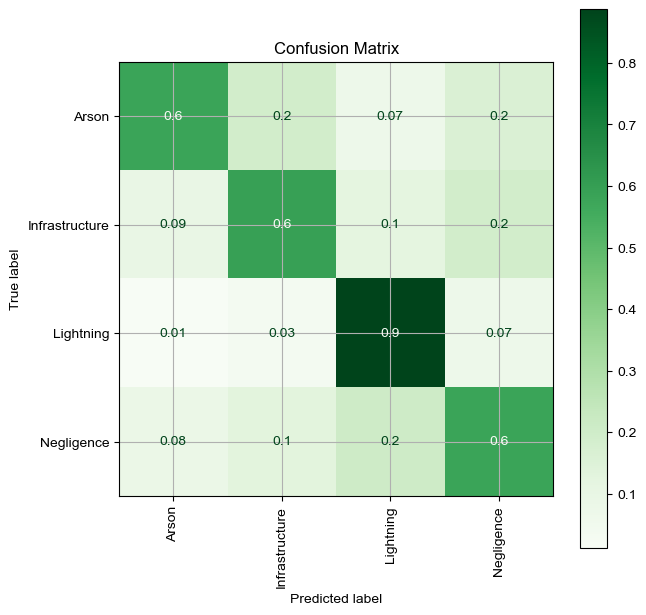

In [11]:
f,ax = plt.subplots(1,1,figsize=(7,7))

cm= ConfusionMatrixDisplay.from_estimator(model_rf,Z_test,y_test, cmap = 'Greens',normalize= 'true', xticks_rotation='vertical', values_format='.1g', ax=ax)
plt.title("Confusion Matrix")
sns.set(font_scale=.9)
plt.grid(None)

;
plt.rcParams["figure.edgecolor"] = "#FAEEDA"
plt.rcParams["figure.facecolor"] = "#FAEEDA"

### Grid Search

We'll try to optimize our model results by Grid Searching over the available parameters. The output of this section will be a set of parameters that perform best given our data. These parameters will be passed back into our model, which will be rerun.

In [23]:
rf_params = {
    'n_estimators':[50, 100, 150],
    'max_depth': [None, 4,8]
}

In [24]:
gs= GridSearchCV(model_rf, param_grid=rf_params, cv=5, n_jobs=-2)

In [25]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'max_depth': [None, 4, 8],
                         'n_estimators': [50, 100, 150]})

In [27]:
gs.best_params_

{'max_depth': None, 'n_estimators': 150}

In [28]:
# gs.get_params()

In [29]:
rf_params2 = {
    'n_estimators':[200,500],
    'max_depth': [None],
    'min_samples_leaf':[1,2]
}

In [30]:
gs2= GridSearchCV(model_rf, param_grid=rf_params2, cv=5, n_jobs=-2)

In [31]:
gs2.fit(X_train, y_train)

/Users/ryan/miniconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'max_depth': [None], 'min_samples_leaf': [1, 2],
                         'n_estimators': [200, 500]})

In [32]:
gs2.best_score_

0.6941624834356436

The gridsearched params yielded a similar result to the initial model.

### Dimensionality Reduction

Once again we'll look at the available features and evaluate how important they are to the result. We'll remove the less important features and re-run the model with only the important features.

In [33]:
y.value_counts(normalize= True)

Lightning         0.379746
Negligence        0.260411
Infrastructure    0.188273
Arson             0.171570
Name: STAT_CAUSE_DESCR, dtype: float64

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_7947/1173274598.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()[['class_number']].sort_values('class_number', ascending=False)


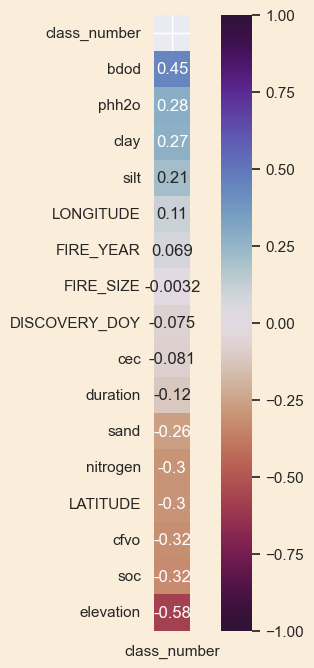

In [34]:
cause_map={'Lightning':0, 'Miscellaneous':1, 'Negligence':3,
         'Equipment Use':4, 'Arson':5, 'Children':6, 'Infrastructure':7}
df['class_number'] = df['STAT_CAUSE_DESCR'].map(cause_map)
plt.figure(figsize = (8,8))

corr = df.corr()[['class_number']].sort_values('class_number', ascending=False)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1)
# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(corr, mask = mask, square = True, cmap = 'twilight_shifted_r', annot = True, vmin = -1, vmax = 1);

In [35]:
#lets try dropping categories between -.1 and .1 correlation values
df.columns

Index(['DISCOVERY_DOY', 'STAT_CAUSE_DESCR', 'STATE', 'SOURCE_SYSTEM_TYPE',
       'duration', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE',
       'SOURCE_REPORTING_UNIT_NAME', 'FIRE_YEAR', 'FIRE_SIZE', 'elevation',
       'bdod', 'cec', 'cfvo', 'clay', 'nitrogen', 'phh2o', 'sand', 'silt',
       'soc', 'class_number'],
      dtype='object')

### Defining X & y

We'll redefine our X and y given the new list of important features.

In [36]:
X = df[[ 'elevation', 'bdod', 'clay', 'silt', 'nitrogen', 'sand', 'FIRE_SIZE_CLASS', 'duration', 'DISCOVERY_DOY']]
X = pd.get_dummies(columns=['FIRE_SIZE_CLASS'], drop_first=True, data=X)

y = df['STAT_CAUSE_DESCR']

In [37]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=2023)

In [38]:
sc = StandardScaler()

Z_train = sc.fit_transform(X_train)

Z_test = sc.transform(X_test)


### Dimensionally Reduced Model

In [39]:
model_rf = RandomForestClassifier()
model_rf.fit(Z_train, y_train)
model_rf.score(Z_test, y_test)

0.6455659835280597

This model performed worse than the initial model. We'll proceed with the initial model at an accuracy of 69%, which beats the baseline condition